In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decpomdp import DecPOMDP
import time
import random
import os
from constant import Constants
import gc 
gc.enable()
from matplotlib import rc
plt.rcParams["font.family"] = "Arial"

In [2]:
#set problem 
file_name = "dectiger"
planning_horizon = 3
num_iterations = 5
sota_ = False
game_type = "stackelberg"


problem = DecPOMDP(file_name,horizon=planning_horizon)
Constants.initialize(problem)
constant = Constants.get_instance()
from pbvi import PBVI
print(f"game size :\n\t|S| = {len(problem.states)}")
print(f"\t|Z| = {problem.num_joint_observations}\n\t|U| = {problem.num_joint_actions} with |U_i| = {problem.num_actions[0]}")
print(f"intiial_belief : {problem.actions}")



game size :
	|S| = 2
	|Z| = 4
	|U| = 9 with |U_i| = 3
intiial_belief : [['listen', 'open-left', 'open-right'], ['listen', 'open-left', 'open-right']]


In [3]:
#see reward matrix of both player
print(f"REWARD MATRIX OF {game_type} {problem.name} GAME")
print("\nLeader :")
print(f"{pd.DataFrame(constant.REWARDS[game_type][0],columns=problem.states)}")
print("\nFollower :")
print(f"{pd.DataFrame(constant.REWARDS[game_type][1],columns=problem.states)}")



REWARD MATRIX OF stackelberg dectiger GAME

Leader :
   tiger-left  tiger-right
0        -2.0         -2.0
1      -101.0          9.0
2         9.0       -101.0
3      -101.0          9.0
4       -50.0         20.0
5      -100.0       -100.0
6         9.0       -101.0
7      -100.0       -100.0
8        20.0        -50.0

Follower :
   tiger-left  tiger-right
0       -20.0        -87.0
1       -98.0         -7.0
2       -66.0        -70.0
3       -73.0        -84.0
4        -7.0        -88.0
5       -15.0         -7.0
6        13.0        -32.0
7       -90.0        -26.0
8       -47.0        -97.0


In [4]:
def initialize_database():
    database = {"gametype":[],
                "SOTA" : [],
                "horizon": [],
                    "iterations" : [],
                    "time" : [],
                    "number_of_beliefs" : [],
                    "values":[],
                    "density" : []
                    # "gap":[]
                    }
    return database

def add_to_database(database,SOTA,horizon,game_type,num_iterations,average_time,num_beliefs,values,density):
    sota = {True:"State of the Art" , False:"Stackelberg"}
    database["gametype"].append(game_type)
    database["horizon"].append(horizon)
    database["SOTA"].append(sota[SOTA])
    database["iterations"].append(num_iterations)
    database["time"].append(average_time)
    database["number_of_beliefs"].append(num_beliefs)
    database["values"].append(values)
    database["density"].append(density)
    return

def run_experiment(iterations,density):
    stackelberg_policy = {True : {}, False :{}}
    database = initialize_database()


    for type in ["cooperative","zerosum","stackelberg"]:
        for sota in (True,False):
            for horizon in range(1,planning_horizon+1):
                game = PBVI(problem=problem,horizon=horizon,density=density,gametype=type,limit=100,sota=sota)
                values, times = game.solve(iterations)
                #at the last horizon of the stackelberg game
                if type=="stackelberg" and horizon==planning_horizon:
                    if sota==False: SL_SF = values[-1]
                    if sota==True: WL_WF = values[-1]
                    print("\nEXTRACTING STACKELBERG POLICIES ... ")
                    stackelberg_policy[sota][0] = game.extract_leader_policy(0,timestep=0)
                    stackelberg_policy[sota][1] = game.extract_follower_policy(0,timestep=0)
                add_to_database(database,sota,horizon,type,iterations,times,game.belief_space.belief_size(),values,density)
    print("calculating stackelberg comparsion matrix...")
    #get policy value from strock stackelberg leader and blind agent
    SL_WF = game.DP(0,0,stackelberg_policy[False][0],stackelberg_policy[True][1])
    #get policy val ue from weak stackelberg leader and strong stackelberg follower
    WL_SF =  game.DP(0,0,stackelberg_policy[True][0],stackelberg_policy[False][1])


    # make stackelberg comparison matrix 
    matrix = {"Strong Leader" : {"Strong Follower" : SL_SF , "Blind Follower" : SL_WF}, "Weak Leader" : {"Strong Follower" : WL_SF, "Blind Follower" : WL_WF }}
    return database, matrix


def run_experiment_increasing_density(iterations,initial_density):
    stackelberg_policy = {True : {}, False :{}}
    database = initialize_database()

    for type in ["cooperative","zerosum","stackelberg"]:
        for sota in (True,False):
            for horizon in range(1,planning_horizon+1):
                game = PBVI(problem = problem , horizon = horizon , density = initial_density ,  gametype=type , limit=1000 , sota=sota)
                values, times ,densities, belief_sizes = game.solve_sampled_densities(iterations,initial_density)
                #extract value of Strong
                if type=="stackelberg" and horizon==planning_horizon:
                    if sota==False: WL_SF = values[-1] #take value at 0 timestep
                    if sota==True: SL_WF = values[-1]
                    print("\nEXTRACTING STACKELBERG POLICIES ... ")
                    stackelberg_policy[sota][0] = game.extract_leader_policy(0,timestep=0)
                    stackelberg_policy[sota][1] = game.extract_follower_policy(0,timestep=0)
                add_to_database(database,sota,horizon,type,iterations,times,belief_sizes,values,densities)
    print("calculating stackelberg comparsion matrix...")

    #get policy value from strong stackelberg leader and blind follower
    WL_WF = game.DP(0,0,stackelberg_policy[False][0],stackelberg_policy[True][1])
    #get policy value from weak stackelberg leader and strong stackelberg follower
    SL_SF =  game.DP(0,0,stackelberg_policy[True][0],stackelberg_policy[False][1])


    # make stackelberg comparison matrix 
    matrix = {"Strong Leader" : {"Strong Follower" : SL_SF , "Blind Follower" : SL_WF}, "Weak Leader" : {"Strong Follower" : WL_SF, "Blind Follower" : WL_WF }}
    return database, matrix

def run_single_experiment(problem,horizon,density,gametype,limit,sota,iterations):
    game = PBVI(problem=problem,horizon=planning_horizon,density=density,gametype=gametype,limit=1000,sota=True)
    return game.solve(iterations)

In [5]:
values,times = run_single_experiment(problem,planning_horizon,density=0.00000001,gametype=game_type,limit=1000,sota=True,iterations=num_iterations)
values

			 Solving stackelberg dectiger GAME WITH SOTA True 3 
[(0, array([0.5, 0.5])), (1, array([0.96979866, 0.03020134])), (2, array([0.03020134, 0.96979866])), (3, array([9.99031124e-01, 9.68876343e-04])), (4, array([9.68876343e-04, 9.99031124e-01])), (5, array([9.99969799e-01, 3.02009694e-05])), (6, array([3.02009694e-05, 9.99969799e-01]))]
	belief expansion done, belief space size = 7

iteration : 1
========================= backup at timestep 2 =========================== 

========== Backup done, veryfing calulations for next timestep backup ==========
False
(0, array([0.5, 0.5]))
belief = [0.5 0.5], max-plane vector = [array([-2.,  9.]), array([-20.,  -7.])] , value = (3.499999999999999, -13.499999999999998)/(3.499999999999999, -13.499999999999998) , tabular alpha = [array([-2.,  9.]), array([-20.,  -7.])]  ,tabular value = (3.499999999999999, -13.499999999999998)
(1, array([0.96979866, 0.03020134]))
belief = [0.96979866 0.03020134], max-plane vector = [array([   9., -100.]), array([

SystemExit: 

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
database, matrix = run_experiment_increasing_density(num_iterations,initial_density=0.001)
pd.DataFrame(database)

			 Solving cooperative dectiger GAME WITH SOTA True 1 
iteration : 1 , density = 0.001
	belief expansion done, belief space size = 3

========================= backup at timestep 1 =========================== 
========== Backup done, veryfing calulations for next timestep backup ==========
========================= backup at timestep 0 =========================== 
========== Backup done, veryfing calulations for next timestep backup ==========
iteration : 2 , density = 0.29447726973755983
	belief expansion done, belief space size = 3

========================= backup at timestep 1 =========================== 
========== Backup done, veryfing calulations for next timestep backup ==========
========================= backup at timestep 0 =========================== 
========== Backup done, veryfing calulations for next timestep backup ==========
iteration : 3 , density = 0.4081029011765343
	belief expansion done, belief space size = 3

========================= backup at timestep 1 =====

,gametype,SOTA,horizon,iterations,time,number_of_beliefs,values,density
0,cooperative,State of the Art,1,5,"[0.008183002471923828, 0.015170097351074219, 0...","[3, 3, 3, 3, 3]","[(18.0, 18.0), (18.0, 18.0), (18.0, 18.0), (18...","[0.001, 0.29447726973755983, 0.408102901176534..."
1,cooperative,State of the Art,2,5,"[0.01912236213684082, 0.03777003288269043, 0.0...","[5, 3, 3, 3, 3]","[(27.0, 27.0), (27.0, 27.0), (27.0, 27.0), (27...","[0.001, 0.29447726973755983, 0.408102901176534..."
2,cooperative,State of the Art,3,5,"[0.03810882568359375, 0.06610393524169922, 0.0...","[7, 3, 3, 3, 3]","[(36.0, 36.0), (36.0, 36.0), (36.0, 36.0), (36...","[0.001, 0.29447726973755983, 0.408102901176534..."
3,cooperative,Stackelberg,1,5,"[0.11467576026916504, 0.23077893257141113, 0.3...","[3, 3, 3, 3, 3]","[(18.0, 18.0), (18.0, 18.0), (18.0, 18.0), (18...","[0.001, 0.29447726973755983, 0.408102901176534..."
4,cooperative,Stackelberg,2,5,"[0.27028417587280273, 0.4787161350250244, 0.87...","[5, 3, 3, 3, 3]","[(27.0, 27.0), (27.0, 27.0), (27.0, 27.0), (27...","[0.001, 0.29447726973755983, 0.408102901176534..."
5,cooperative,Stackelberg,3,5,"[0.7187230587005615, 1.033987045288086, 1.3475...","[7, 3, 3, 3, 3]","[(36.0, 36.0), (36.0, 36.0), (36.0, 36.0), (36...","[0.001, 0.29447726973755983, 0.408102901176534..."
6,zerosum,State of the Art,1,5,"[0.17796587944030762, 0.34558796882629395, 0.5...","[3, 3, 3, 3, 3]","[(-150.0, 150.0), (-150.0, 150.0), (-150.0, 15...","[0.001, 0.29447726973755983, 0.408102901176534..."
7,zerosum,State of the Art,2,5,"[0.3625526428222656, 0.6824676990509033, 0.967...","[5, 3, 3, 3, 3]","[(-225.0, 225.0), (-225.0, 225.0), (-225.0, 22...","[0.001, 0.29447726973755983, 0.408102901176534..."
8,zerosum,State of the Art,3,5,"[0.6463899612426758, 1.0553760528564453, 1.465...","[7, 3, 3, 3, 3]","[(-300.0, 300.0), (-300.0, 300.0), (-300.0, 30...","[0.001, 0.29447726973755983, 0.408102901176534..."
9,zerosum,Stackelberg,1,5,"[0.13187885284423828, 0.2943379878997803, 0.47...","[3, 3, 3, 3, 3]","[(-150.0, 150.0), (-150.0, 150.0), (-150.0, 15...","[0.001, 0.29447726973755983, 0.408102901176534..."


In [ ]:
def plots(table):
    plots = {}
    for gametype in ["cooperative","stackelberg","zerosum"]:
        fig, ax = plt.subplots()
        data = table[table["gametype"]==gametype][table["horizon"]==planning_horizon]
        x = [i+1 for i in range(0,num_iterations)]
        for sota in ["Stackelberg","State of the Art"]:
            y = [values[0] for values in np.array(data["values"][data["SOTA"]==sota])[0]]
            ax.plot(x,y,label = sota)
            ax.legend()
            ax.set_xlabel("Iterations")
            ax.set_ylabel("leader value")
        ax.set_title(f"{gametype} {file_name} game, Horizon = {planning_horizon}")
        #save plot in dictionary 
        plots[game_type] = fig
        plt.show()
        

In [ ]:
def horizon_value_plot(table):
    bar_width = 0.35

    for gametype in ["cooperative","stackelberg","zerosum"]:
        colors = ['red', 'tan']
        horizons = np.arange(planning_horizon,step=1)
        sota_values = []
        non_sota_values = []
        for horizon in range(1,planning_horizon+1):
            data = table[table["gametype"]==gametype][table["horizon"]==horizon]
            sota_values.append(np.average([values[0] for values in np.array(data["values"][data["SOTA"]=="State of the Art"])[0]]))
            non_sota_values.append(np.average([values[0] for values in np.array(data["values"][data["SOTA"]=="Stackelberg"])[0]]))
    
        # plotting
        plt.bar(horizons, sota_values, bar_width, label='sota')
        plt.bar(horizons + bar_width, non_sota_values, bar_width, label='non-sota')

        # labels
        plt.xlabel("Horizon")
        plt.ylabel('Leader value')
        plt.title(f"{gametype} {file_name} game")
        plt.xticks(horizons+ bar_width / 2,horizons)


        plt.legend()
        plt.show()


/var/folders/sz/1rmm95756pqfc118zm4kfbt40000gn/T/ipykernel_92839/2230657074.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = table[table["gametype"]==gametype][table["horizon"]==planning_horizon]


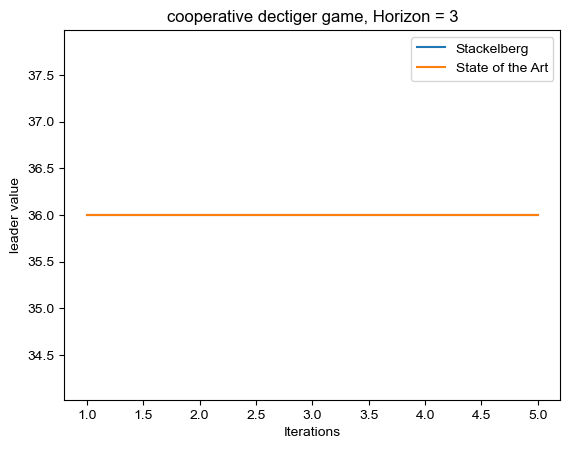

/var/folders/sz/1rmm95756pqfc118zm4kfbt40000gn/T/ipykernel_92839/2230657074.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = table[table["gametype"]==gametype][table["horizon"]==planning_horizon]


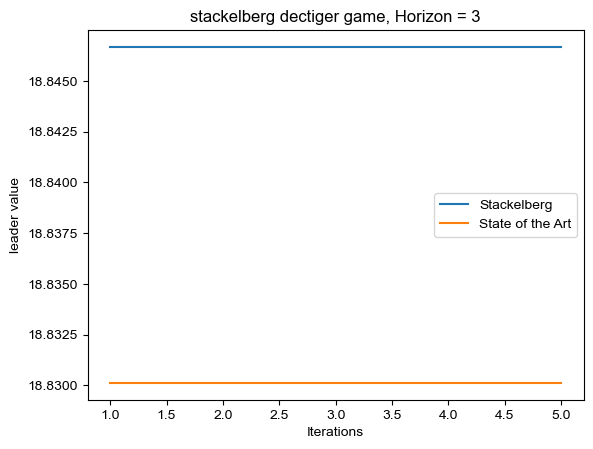

/var/folders/sz/1rmm95756pqfc118zm4kfbt40000gn/T/ipykernel_92839/2230657074.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = table[table["gametype"]==gametype][table["horizon"]==planning_horizon]


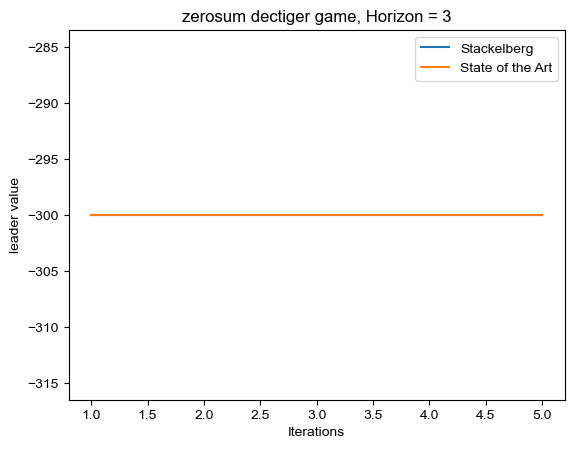

/var/folders/sz/1rmm95756pqfc118zm4kfbt40000gn/T/ipykernel_92839/170136810.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = table[table["gametype"]==gametype][table["horizon"]==horizon]
/var/folders/sz/1rmm95756pqfc118zm4kfbt40000gn/T/ipykernel_92839/170136810.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = table[table["gametype"]==gametype][table["horizon"]==horizon]
/var/folders/sz/1rmm95756pqfc118zm4kfbt40000gn/T/ipykernel_92839/170136810.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = table[table["gametype"]==gametype][table["horizon"]==horizon]


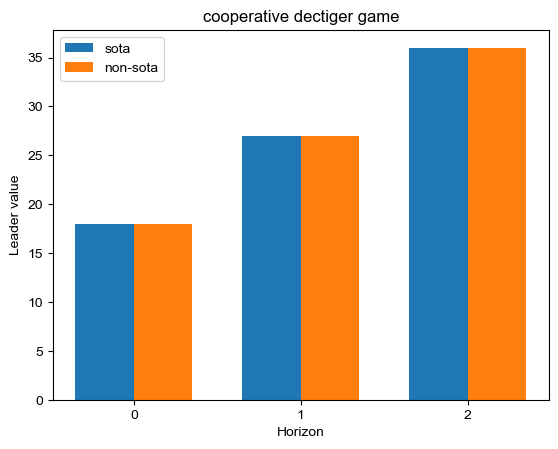

/var/folders/sz/1rmm95756pqfc118zm4kfbt40000gn/T/ipykernel_92839/170136810.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = table[table["gametype"]==gametype][table["horizon"]==horizon]
/var/folders/sz/1rmm95756pqfc118zm4kfbt40000gn/T/ipykernel_92839/170136810.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = table[table["gametype"]==gametype][table["horizon"]==horizon]
/var/folders/sz/1rmm95756pqfc118zm4kfbt40000gn/T/ipykernel_92839/170136810.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = table[table["gametype"]==gametype][table["horizon"]==horizon]


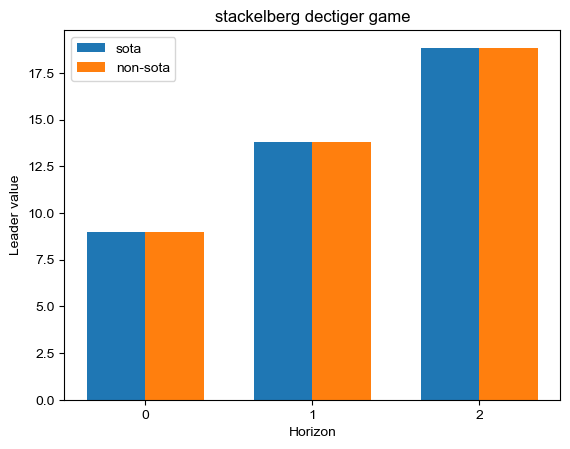

/var/folders/sz/1rmm95756pqfc118zm4kfbt40000gn/T/ipykernel_92839/170136810.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = table[table["gametype"]==gametype][table["horizon"]==horizon]
/var/folders/sz/1rmm95756pqfc118zm4kfbt40000gn/T/ipykernel_92839/170136810.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = table[table["gametype"]==gametype][table["horizon"]==horizon]
/var/folders/sz/1rmm95756pqfc118zm4kfbt40000gn/T/ipykernel_92839/170136810.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = table[table["gametype"]==gametype][table["horizon"]==horizon]


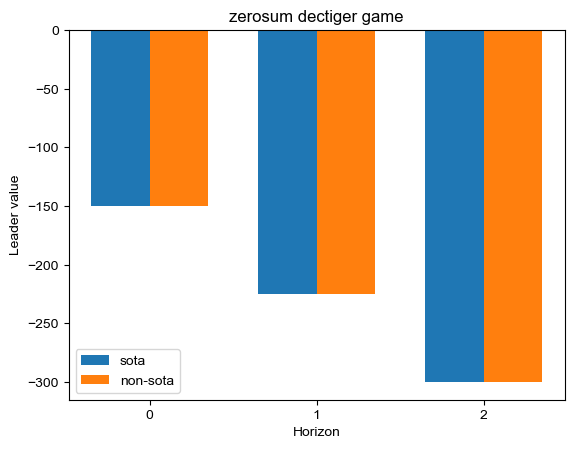

In [ ]:
plots(pd.DataFrame(database))
horizon_value_plot(pd.DataFrame(database))

In [ ]:
print("Stackelberg Matrix")
pd.DataFrame(matrix)

Stackelberg Matrix


,Strong Leader,Weak Leader
Strong Follower,29.280854,"(18.846666207031255, -55.62653421533204)"
Blind Follower,"(18.830118074973438, -13.499999999999998)",29.280854


In [ ]:
algorithms = ['State of the Art','PBVI']
columns = pd.MultiIndex.from_product([algorithms, ['time', 'value', 'iteration']])
data = pd.DataFrame(database)

# Create an empty DataFrame with the specified columns
df = pd.DataFrame(columns=columns)

for gametype in ["cooperative","zerosum","stackelberg"]:
    game_data = []
    for horizon in range(planning_horizon):
        new_row_data = []
        for SOTA in ["State of the Art","Stackelberg"]:
            current_data = data[data["SOTA"]==SOTA][data["horizon"]==horizon+1][data["gametype"]==gametype]
            time = current_data["time"].values[0][num_iterations-1]
            value = current_data["values"].values[0][num_iterations-1]
            iteration = current_data["iterations"].values[0]
            new_row_data = new_row_data + [time,value,iteration]
        game_data.append(new_row_data)
    new_row = pd.DataFrame(game_data, columns=columns)
    df = df.merge(new_row, how='outer')

df.set_index(np.array([f"{problem.name}{horizon}"for gametype in ["cooperative","zerosum","stackelberg"]for horizon in range(planning_horizon)]))

/var/folders/sz/1rmm95756pqfc118zm4kfbt40000gn/T/ipykernel_92839/3292250146.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_data = data[data["SOTA"]==SOTA][data["horizon"]==horizon+1][data["gametype"]==gametype]
/var/folders/sz/1rmm95756pqfc118zm4kfbt40000gn/T/ipykernel_92839/3292250146.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_data = data[data["SOTA"]==SOTA][data["horizon"]==horizon+1][data["gametype"]==gametype]
/var/folders/sz/1rmm95756pqfc118zm4kfbt40000gn/T/ipykernel_92839/3292250146.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_data = data[data["SOTA"]==SOTA][data["horizon"]==horizon+1][data["gametype"]==gametype]
/var/folders/sz/1rmm95756pqfc118zm4kfbt40000gn/T/ipykernel_92839/3292250146.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_data = data[data["SOTA"]==SOTA][data["horizon"]==horizon+1][

State of the Art                                             \
                      time                                      value   
dectiger0         0.035251                               (18.0, 18.0)   
dectiger1         0.091216                               (27.0, 27.0)   
dectiger2         0.160840                               (36.0, 36.0)   
dectiger0         0.845506                            (-150.0, 150.0)   
dectiger1         1.536217                            (-225.0, 225.0)   
dectiger2         2.327018                            (-300.0, 300.0)   
dectiger0         0.627691   (8.999374999999999, -13.499999999999998)   
dectiger1         1.507610  (13.783620376238725, -13.499999999999998)   
dectiger2         2.136266  (18.830118074973438, -13.499999999999998)   

                         PBVI                                             \
          iteration      time                                      value   
dectiger0         5  0.616621                               (18.0, 18.0)   
dectiger1         5  1.368260                               (27.0, 27.0)   
dectiger2         5  2.021718                               (36.0, 36.0)   
dectiger0         5  0.774434                            (-150.0, 150.0)   
dectiger1         5  1.470048                            (-225.0, 225.0)   
dectiger2         5  1.962296                            (-300.0, 300.0)   
dectiger0         5  0.596555            (8.999375, -27.677578125000004)   
dectiger1         5  1.152762  (13.791248437500002, -41.605570898437506)   
dectiger2         5  1.809802   (18.846666207031255, -55.62653421533204)   

                     
          iteration  
dectiger0         5  
dectiger1         5  
dectiger2         5  
dectiger0         5  
dectiger1         5  
dectiger2         5  
dectiger0         5  
dectiger1         5  
dectiger2         5